In [20]:
# To generate GIFs
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [21]:
import tensorflow as tf
import os, sys, glob
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import random
import datetime


DATETIME_NOW = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
SEED = 42
MODEL_NAME = 'DC_GAN'
FILE_RATIO = 1
PATCH_HOP_DISTANCE = 1.05
DATASET_DIR = "C:\\Users\\User\\Documents\\cer_dataset_16k_resampled_split\\"


sys.path.append('src')
sys.path.append('src/models')
from models.get_models import get_model
import models.yamnet_tf2.params as params
params = params.Params(sample_rate=16000, patch_hop_seconds=PATCH_HOP_DISTANCE) # 0.25

# from dataload_utils.data_load import get_dataset, get_filenames_and_classnames_list
import dataload_utils.data_load as data_load
from dataload_utils.data_aug import mix_up


# SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)

# parent_dir = "C:\\Users\\User\\Documents\\cer_dataset_16k_flattened_resampled\\"
dataset_loader = data_load.Dataset_loader(DATASET_DIR, params)
filenames_all = dataset_loader.__filenames_all__
classes = dataset_loader.__classes__
num_classes = dataset_loader.__num_classes__
print("classes: {}, num_classes: {}".format(classes, num_classes))

# To do real shuffling
AUTOTUNE = tf.data.AUTOTUNE
batch_size=64
random.shuffle(filenames_all)
filenames_all=filenames_all[:int(len(filenames_all)*FILE_RATIO)]
filenames_train = filenames_all[:int(len(filenames_all)*0.7)]
filenames_eval = filenames_all[int(len(filenames_all)*0.7):int(len(filenames_all)*0.9)]
filenames_test = filenames_all[int(len(filenames_all)*0.9):]

# Training set preparation
dataset_aug = dataset_loader.get_dataset(filenames_train, augment=True)
train_dataset = dataset_aug.shuffle(batch_size*2).batch(batch_size) # Batch before doing mixup
eval_dataset = dataset_loader.get_dataset(filenames_eval, augment=False).shuffle(batch_size*2).batch(batch_size)
test_dataset = dataset_loader.get_dataset(filenames_test, augment=False).shuffle(batch_size*2).batch(batch_size)
train_dataset = train_dataset.map(lambda x,y: x)
eval_dataset = eval_dataset.map(lambda x,y: x)
test_dataset = test_dataset.map(lambda x,y: x)

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
eval_dataset = eval_dataset.cache().prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(AUTOTUNE)

# length = len(list(dataset_train_eval))
# print("Total length of dataset: ", length)

# Paths
training_path = "./training/{}".format(DATETIME_NOW)

model_training_path = training_path + "/{}".format(MODEL_NAME)
ckp_path = model_training_path + "/checkpoints/cp.ckpt"
log_path = model_training_path + "/logs/fit"    
hd5_path = model_training_path + "/model.hd5"
cfm_path = model_training_path + "/confusion_matrix.png"


Number of files in Class_00_Modified_car_engines: 8071
Number of files in Class_01_Regular_Vehicles: 9539
Number of files in Class_02_Tools_and_Mechanisms: 13307
Number of files in Class_03_Environmental_Sounds: 10488
Number of files:  41405
classes: ['Class_00_Modified_car_engines', 'Class_01_Regular_Vehicles', 'Class_02_Tools_and_Mechanisms', 'Class_03_Environmental_Sounds'], num_classes: 4


In [22]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
BUFFER_SIZE = 60000
BATCH_SIZE = 256

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [23]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
# BUFFER_SIZE = 60000
# BATCH_SIZE = 256
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# for x, y in eval_dataset.take(1):
#     print(x,y)

ValueError: too many values to unpack (expected 2)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [24]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

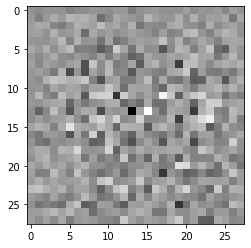

In [25]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [26]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00058378]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [28]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [30]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [31]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [35]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [36]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled" (as a graph I believe).
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)           # Generate images based on noise

    real_output = discriminator(images, training=True)           # Output when fed real data
    fake_output = discriminator(generated_images, training=True) # Output when fed fake data

    gen_loss = generator_loss(fake_output)                       # Loss on generator performance
    disc_loss = discriminator_loss(real_output, fake_output)     # Loss on discriminator performance

  # Get gradient for these two loss functions
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Apply gradients to optimizer 
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
# This is model fit but custom
def train(dataset, epochs):  
# For every epoch
  for epoch in range(epochs):
    start = time.time()
    
    # Iterate through every batch of dataset and perform fitting
    for image_batch in dataset:
      train_step(image_batch)

    # Below this is just logging ------------------------------------
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # Print timme taken for epoch
    print ('Time for epoch {} is {} sec'.format(
      epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [51]:
for x in test_dataset.take(1):
    # print(discriminator.predict(x))
    real_output = discriminator(x, training=False)           # Output when fed real data
    print(real_output)

tf.Tensor(
[[ 27.281052 ]
 [359.51944  ]
 [ -4.9693093]
 [217.49422  ]
 [148.03127  ]
 [649.91943  ]
 [ 34.059074 ]
 [479.37195  ]
 [ 37.739517 ]
 [505.9435   ]
 [437.0767   ]
 [255.21951  ]
 [219.25748  ]
 [118.907104 ]
 [ 77.324165 ]
 [457.62726  ]
 [ 89.43053  ]
 [395.67117  ]
 [ 88.65545  ]
 [ 25.743097 ]
 [217.61383  ]
 [ 55.213047 ]
 [ 35.663334 ]
 [175.06097  ]
 [132.01883  ]
 [ 31.366735 ]
 [116.66085  ]
 [302.8844   ]
 [ 20.111185 ]
 [190.96529  ]
 [170.94783  ]
 [198.09406  ]
 [ 50.98666  ]
 [ 81.164635 ]
 [311.57635  ]
 [ 73.36205  ]
 [421.2455   ]
 [ 90.71675  ]
 [162.92807  ]
 [159.6434   ]
 [ 56.10436  ]
 [ 20.46716  ]
 [252.59189  ]
 [285.79352  ]
 [408.8469   ]
 [196.63943  ]
 [933.3327   ]
 [608.0298   ]
 [278.70868  ]
 [291.5815   ]
 [282.22385  ]
 [321.42587  ]
 [215.87073  ]
 [ 65.30875  ]
 [298.2851   ]
 [ 40.951252 ]
 [ 51.997955 ]
 [ 20.074316 ]
 [396.85742  ]
 [129.61526  ]
 [ 83.24298  ]
 [ 12.802408 ]
 [123.97735  ]
 [ 39.54993  ]], shape=(64, 1), dtype=float3

**Generate and save images**


In [38]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

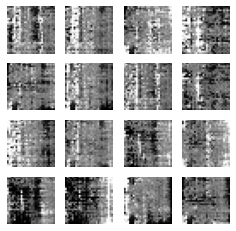

In [39]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [41]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

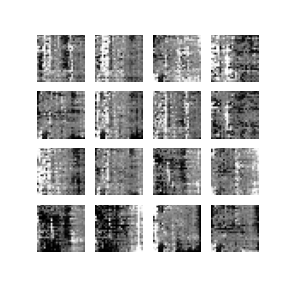

In [42]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [43]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


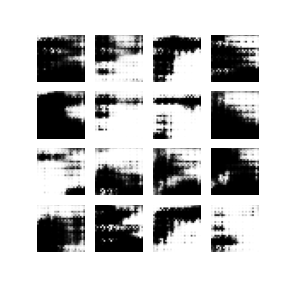

In [44]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
